<a href="https://colab.research.google.com/github/ermeson-alves/UNetpp-RD/blob/main/UNet%2B%2B_Single_Class_ic_2022_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import os
# Path para o diretório de trabalho:
os.chdir("/content/drive/MyDrive/DRIVE COMPARTILHADO/PDI -2/UNet-SegRD")
Path.cwd()

PosixPath('/content/drive/.shortcut-targets-by-id/1X7S_ltY-tCqSYi95ToGWtxwSGUNjW7nS/PDI -2/UNet-SegRD')

# **Treino separado por classe**

#### Visualização:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_img_and_mask(batch_imgs: torch.tensor, batch_masks: torch.tensor, normalize_01=False, title=None):
    '''Recebe um lote de imagens e um lote de mascaras e plota as imagens e as mascaras respectivas
    Args:
    batch_imgs: shape-> (B,C,H,W)
    batch_masks: shape-> (B,H,W)

    '''

    fig, ax = plt.subplots(2, batch_imgs.size()[0], figsize=(4 * batch_imgs.size()[0],7))
    for (i, img), mask in zip(enumerate(batch_imgs), batch_masks):
        if batch_imgs.size()[0]==1:
            if normalize_01:
              img = (img.permute(1,2,0) - img.permute(1,2,0).min())/(img.permute(1,2,0).max() - img.permute(1,2,0).min())
              mask = mask.squeeze()
            else:
              img = img.permute(1,2,0)
              mask = mask.squeeze()

            ax[0].imshow(img); ax[0].set_xticks(np.arange(0,240,40)); ax[0].set_yticks(np.arange(0,240,40))
            ax[1].imshow(mask, cmap='gray'); ax[1].set_xticks(np.arange(0,240,40)); ax[1].set_yticks(np.arange(0,240,40))
        else:
            if normalize_01:
              img = (img.permute(1,2,0) - img.permute(1,2,0).min())/(img.permute(1,2,0).max() - img.permute(1,2,0).min())
              mask = (mask.squeeze())
            else:
              img, mask = img.permute(1,2,0), mask.squeeze()
            ax[0,i].imshow(img); ax[0,i].set_xticks(np.arange(0,240,40)); ax[0,i].set_yticks(np.arange(0,240,40))
            ax[1,i].imshow(mask, cmap='gray'); ax[1,i].set_xticks(np.arange(0,240,40)); ax[1,i].set_yticks(np.arange(0,240,40))

    if title:
      fig.suptitle(title)

    plt.show()

#### Librarys

In [ ]:
%pip install -q segmentation_models_pytorch
%pip install -q pytorch_lightning==1.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.2/826.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.1 MB/s eta 0:00:00


In [ ]:
!pip list | grep pytorch-lightning

pytorch-lightning             1.9.2


In [ ]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import random
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import pandas as pd

# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cuda - Type: Tesla T4


#### Load Dataset

In [ ]:
LESIONS_IDRID = {0: 'MA', 1: 'HE', 2:'EX', 3:'SE', 4:'OD'}
LESIONS_DIARET = {0: 'hardexsudates', 1:'hemorrhages', 2:'redsmalldots', 3:'softexsudates'}

In [ ]:
class IDRIDDataset(Dataset):
    def __init__(self, images_dir: Path, masks_dir: Path, class_id=0, transform=None):
        super().__init__()
        """
        Args:
            image_dir: Path para o diretório de fundoscopias
            mask_dir: Path para o diretório de diretórios de mascaras
            class_id: {0: 'MA', 1: 'HE', 2:'EX', 3:'SE', 4:'OD'}
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.class_id = class_id
        self.transform = transform
        self.images_paths = []
        self.masks_paths = []
        self.images = []
        self.masks = []

        # variavel que armazena qual diretório de lesões será usado
        mask_path4 = sorted(masks_dir.iterdir())[class_id]

        for img_path in sorted(images_dir.glob('*.jpg')):
          # Essa condicional atua no fato de que não há a mesma quantidade de mascara por lesão
          if Path(mask_path4 / (img_path.stem+'_'+LESIONS_IDRID[class_id]+'.tif')).exists():
            mask_path = mask_path4 / (img_path.stem+'_'+LESIONS_IDRID[class_id]+'.tif')
            self.images_paths.append(img_path)
            self.masks_paths.append(mask_path)
            self.images.append(self.img_loader(img_path,dataset='IDRID'))
            self.masks.append(self.img_loader(mask_path,is_mask=True, dataset='IDRID'))

    @staticmethod
    def img_loader(image_path: Path, is_mask=False, dataset='IDRID', size=(224,224)):
        with open(image_path, 'rb') as f:
            if dataset=="DIARETDB":
                if not is_mask:
                    img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, size)
                    return img
                else:
                    mask = cv2.imread(str(image_path), 0)
                    mask = cv2.resize(mask, size)
                    otsu_threshold, image_result = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
                    mask = cv2.threshold(mask, otsu_threshold, 255, cv2.THRESH_BINARY)[1]
                    return mask

            elif dataset=="IDRID":
                if not is_mask:
                    img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, size)

                    return img
                else:
                    mask = cv2.imread(str(image_path))[:, :, 2]
                    mask = cv2.resize(mask, size)
                    otsu_threshold, image_result = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
                    mask = cv2.threshold(mask, otsu_threshold, 255, cv2.THRESH_BINARY)[1]

                    return mask

    def __len__(self):
        assert len(self.images_paths) == len(self.masks_paths)
        return len(self.images_paths)

    def __getitem__(self, idx):
        """Retorna a imagem, sua mascara binária e o nome da imgem em forma de dicionário, aplica transformações se houver"""
        image = self.images[idx]
        true_mask = self.masks[idx] / 255
        true_mask = np.expand_dims(true_mask, 2)

        if self.transform:
            transformed = self.transform(image=image, mask=true_mask)
            image = transformed["image"]
            true_mask = transformed["mask"].permute(2,0,1)
        else:
          image = torch.from_numpy(image)
          true_mask = torch.from_numpy(true_mask).permute(2,0,1)

        return {'image': image, 'mask': true_mask, 'name_img': self.images_paths[idx].name}

############################################################################################################################################

def adaptar_DIARET(root_dir: Path, dir_fundus_imgs: Path, dir_groundtruths_imgs: Path, *annotations_path: Path):
    """Com base nos arquivos de anotações .txt do dataset diaretdb1_v1.1, essa função cria uma divisão melhor das
    imagens em TESTSET e TRAINSET para facilitar futuras utilizações desses dados

    Args:
      root_dir: path para o dataset Diaretdb1_v1.1
      dir_fundus_imgs: path para a pasta de fundoscopias (ddb1_fundusimages)
      dir_groundtruths: path para a pasta com subpastas de mascaras (ddb1_groundtruth)
      annotations_path: path para o .txt que contem as labels de treino ou teste (testset.txt ou trainset.txt)
    """


    def create_dir(path:Path):
        if not path.exists():
            if not path.parent.exists():
                create_dir(path.parent)
            path.mkdir()

    for annotation_path in annotations_path:
        if (root_dir/str(annotation_path.stem).upper()).exists():
          print(f"{str(root_dir/str(annotation_path.stem).upper())} já existe.")
          continue

        path_base = Path(root_dir/str(annotation_path.stem).upper())
        create_dir(path_base/dir_fundus_imgs.name)
        labels = pd.read_csv(annotation_path, header=None).sort_values(by=0, ascending=True)
        print("Nova pasta com fundoscopias criada.")
        for label in labels[0]:
            # Salvar a imagem de fundoscopia das anotações na pasta de fundoscopias:
            img_fundus = Image.open(dir_fundus_imgs/label).convert('RGB')
            img_fundus.save(path_base/dir_fundus_imgs.name/label)

        for dir_masks in ['hardexudates', 'hemorrhages', 'redsmalldots', 'softexudates']:
            create_dir(path_base/'ddb1_groundtruth'/dir_masks)

            for label in labels[0]:
                # Salvar a mascara:
                mask = Image.open(dir_groundtruths_imgs/dir_masks/label).convert('L')
                mask.save(path_base/'ddb1_groundtruth'/dir_masks/label)
            print("Nova pasta com mascaras de lesões criada.")


############################################################################################################################################

class DIARETDBDataset(Dataset):
    def __init__(self, images_dir:Path, masks_dir:Path, class_id=0, transform=None):
        """
          O link de download do dataset, https://www.it.lut.fi/project/imageret/diaretdb1/diaretdb1_v_1_1.zip,
        atualmente, 11/05/2023, não está funcionando, talvez por estar fora do ar.

        Args:
           Args:
            image_dir: Path para o diretório de fundoscopias
            mask_dir: Path para o diretório de diretórios de mascaras
            class_id: 0: hardexsudates (EX),
                      1: hemorrhages (HE),
                      2: redsmalldots (MA),
                      3: softexsuates (SE)
        """

        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.class_id = class_id
        self.transform = transform
        self.images_paths = []
        self.masks_paths = []
        self.images = []
        self.masks = []

        # variavel que armazena qual diretório de lesões será usado
        mask_path4 = sorted(masks_dir.iterdir())[class_id]

        for img_path in sorted(images_dir.glob('*.png')):
          mask_path = mask_path4 / img_path.name
          self.images_paths.append(img_path)
          self.masks_paths.append(mask_path)
          self.images.append(IDRIDDataset.img_loader(img_path,dataset='DIARETDB'))
          self.masks.append(IDRIDDataset.img_loader(mask_path,is_mask=True, dataset='DIARETDB'))


    def __len__(self):
        assert len(self.images) == len(self.masks)
        return len(self.images)

    def __getitem__(self, idx):
        """Retorna a imagem, sua mascara binária e o nome da imgem em forma de dicionário, aplica transformações se houver"""
        image = self.images[idx]
        true_mask = self.masks[idx] / 255
        true_mask = np.expand_dims(true_mask, 2)

        if self.transform:
            transformed = self.transform(image=image, mask=true_mask)
            image = transformed["image"]
            true_mask = transformed["mask"].permute(2,0,1)
        else:
          image = torch.from_numpy(image)
          true_mask = torch.from_numpy(true_mask).permute(2,0,1)

        return {'image': image, 'mask': true_mask, 'name_img': self.images_paths[idx].name}

In [ ]:
# adaptar_DIARET(Path('./datasets/Datasets_RD/ddb1_v_1_1'),
#                Path('./datasets/Datasets_RD/ddb1_v_1_1/resources/images/ddb1_fundusimages'),
#                Path('./datasets/Datasets_RD/ddb1_v_1_1/resources/images/ddb1_groundtruth'),
#                Path('./datasets/Datasets_RD/ddb1_v_1_1/resources/traindatasets/trainset.txt'),
#                Path('./datasets/Datasets_RD/ddb1_v_1_1/resources/testdatasets/testset.txt'))

# #--->> DIARETDB1_v1.1 treino
# TRAINSET_IMGS = Path("./datasets/Datasets_RD/ddb1_v_1_1/TRAINSET/ddb1_fundusimages")
# TRAINSET_DIR_MASKS = Path("./datasets/Datasets_RD/ddb1_v_1_1/TRAINSET/ddb1_groundtruth")
# #--->> DIARETDB1_v1 teste
# TESTSET_IMGS = Path("./datasets/Datasets_RD/ddb1_v_1_1/TESTSET/ddb1_fundusimages")
# TESTSET_DIR_MASKS = Path("./datasets/Datasets_RD/ddb1_v_1_1/TESTSET/ddb1_groundtruth")

#--->> IDRID treino
TRAINSET_IMGS = Path("datasets/A. Segmentation/1. Original Images/a. Training Set")
TRAINSET_DIR_MASKS = Path("datasets/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set")
#--->> IDRID teste
TESTSET_IMGS = Path("datasets/A. Segmentation/1. Original Images/b. Testing Set")
TESTSET_DIR_MASKS = Path("datasets/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set")


data_transforms = {
    'train': A.Compose([
                A.Resize(224, 224),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.5),
                A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # DUVIDA AQUI SE USO ESSESMETROS DE MEDIA E DESVIO PADRÃO
                ToTensorV2(),
    ]),
    'test': A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # DUVIDA AQUI SE USO ESSESMETROS DE MEDIA E DESVIO PADRÃO
        ToTensorV2()
    ]),}

##### Definição dos Datasets e DataLoaders

In [ ]:
# datasets
type_dataset = int(input("Qual tipo de dataset carregar?\n\n0: Exsudatos duros\n1: Hemorragias\n2: Microaneurismas\n3: Exsudatos Moles\n\n"))

train_dataset = DIARETDBDataset(TRAINSET_IMGS, TRAINSET_DIR_MASKS, type_dataset, transform=data_transforms['train'])
print(f"\nShape de uma amostra: {train_dataset[0]['image'].shape, train_dataset[0]['mask'].shape}")

n_val = int(len(train_dataset) * 0.1)
n_train = len(train_dataset) - n_val
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

test_dataset = DIARETDBDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, type_dataset, transform=data_transforms['test'])

# dataloaders
batch_size = 4

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# # datasets
# type_dataset = int(input("Qual tipo de dataset carregar?\n\n0: Microaneurismas\n1: Hemorragias\n2: Exsudatos duros\n3: Exsudatos Moles\n4: Disco Óptico\n\n"))

# train_dataset = IDRIDDataset(TRAINSET_IMGS, TRAINSET_DIR_MASKS, type_dataset, transform=data_transforms['train'])
# print(f"\n\nDataset de treino carregado. Tipo: {LESIONS_IDRID[type_dataset]}.\nShape de uma amostra: {train_dataset[0]['image'].shape, train_dataset[0]['mask'].shape}")

# n_val = int(len(train_dataset) * 0.1)
# n_train = len(train_dataset) - n_val
# train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# test_dataset = IDRIDDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, type_dataset, transform=data_transforms['test'])

# # dataloaders
# batch_size = 4

# train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# val_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


##### Plot

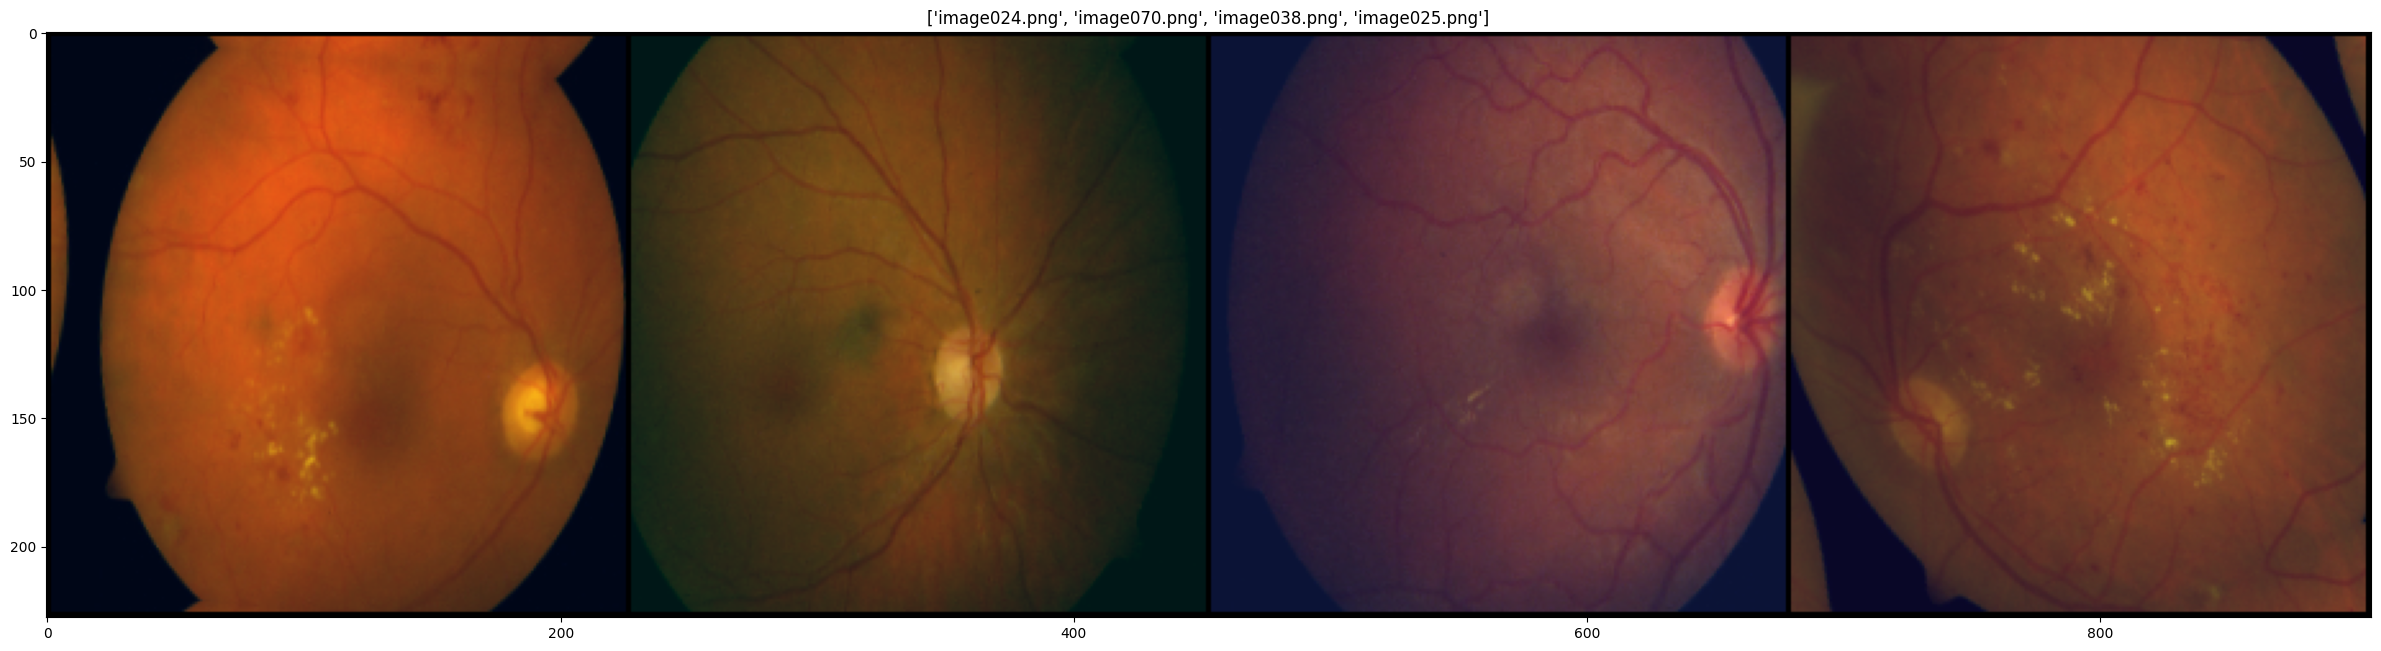

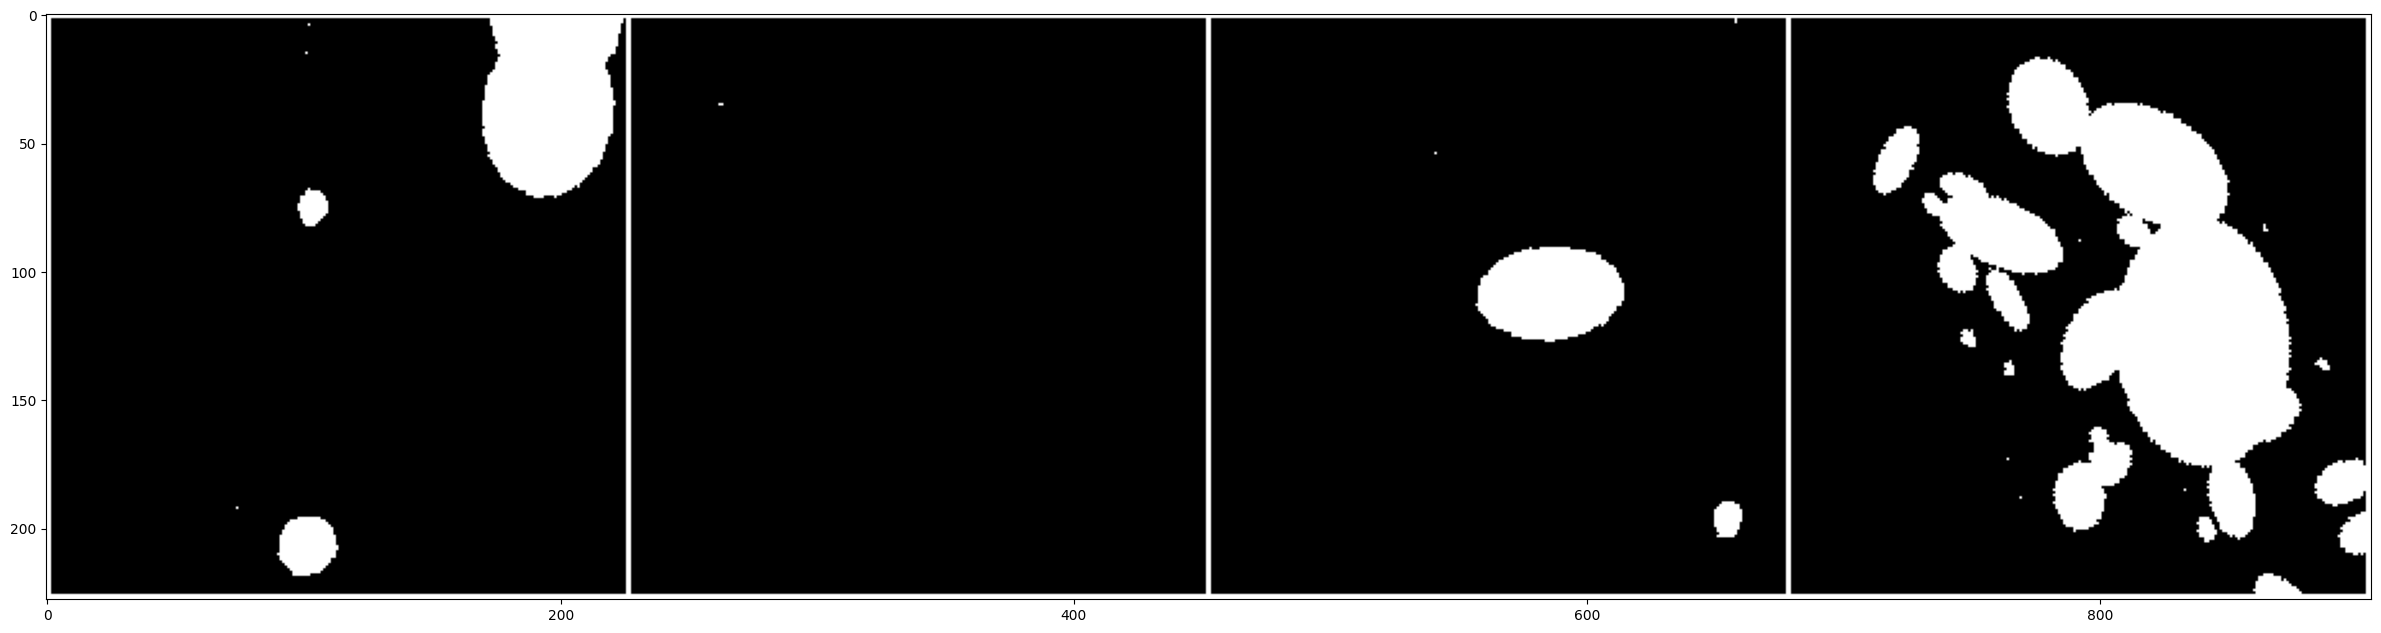

In [ ]:
batch = next(iter(train_dl))

import torchvision
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [30, 20]

def imshow_img(inp, title=str(batch['name_img'])):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def imshow_mask(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs = batch['image']
masks = batch['mask']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, normalize=True)
out2 = torchvision.utils.make_grid(masks, normalize=True, pad_value=255)

imshow_img(out)
imshow_mask(out2)

In [ ]:
print(f"values in masks {torch.unique(batch['mask'])}")
print(batch['image'].shape, batch['mask'].shape)

values in masks tensor([0., 1.], dtype=torch.float64)
torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])


#### Treino U-Net

##### Definição do Lighting Module

In [ ]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

class RetinopatiaModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, loss_name, lr, beta,  **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.lr = lr

        # for image segmentation dice loss could be the best first choice

        if loss_name == 'Dice':
            self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        if loss_name == 'Tversky':
            self.loss_fn = smp.losses.TverskyLoss(smp.losses.BINARY_MODE, from_logits=True, beta=beta)
        if loss_name == 'Lovasz':
            self.loss_fn = smp.losses.LovaszLoss(smp.losses.BINARY_MODE, from_logits=True)

        self.save_hyperparameters()

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        loss = outputs[0]["loss"]

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score,
            f"{stage}_loss": loss,

        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

##### Definição Trainers.
Obs: Pedro Usou 6 workers na criação dos Dataloaders

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pprint import pprint
from random import randint


encoders = ['mobilenet_v2', 'vgg16', 'efficientnet-b3', 'resnet50']
for seg_encoder in encoders: # https://github.com/qubvel/segmentation_models.pytorch

  seg_model = 'UnetPlusPlus'  #  Unet, UnetPlusPlus, MAnet, Linknet, FPN, PSPNet, PAN, DeepLabV3,DeepLabV3Plus

  checkpoint_callback = ModelCheckpoint(
        dirpath = f'./checkpoints/treino-single-class/',
        filename=f'Unet++_{seg_encoder}_{LESIONS_DIARET[type_dataset]}',
        # filename=f'Unet++_{seg_encoder}_{LESIONS_IDRID[type_dataset]}',
        #filename=f'lesion-{seg_encoder}-{seg_model}-{k}-{random_num}',
        monitor='valid_dataset_iou',
        mode="max", # ENTENDER PQ MAX
      )


  early_stop_callback = EarlyStopping(
      monitor="valid_loss",
      patience=185,
      verbose=False,
      mode="min"
      )

  model = RetinopatiaModel(seg_model, seg_encoder, in_channels=3, lr=0.001, loss_name='Dice', beta=None, out_classes=1)
  #model = GlaucomaModel(seg_model, seg_encoder, in_channels=3, lr=0.0001, loss_name='Focal', beta=None, out_classes=1)

  trainer = pl.Trainer(
      devices="auto",
      max_epochs=100,
      callbacks = [checkpoint_callback, early_stop_callback],
      accumulate_grad_batches=6,
      accelerator="gpu",
      #logger=wandb_logger,
      #auto_lr_find=True,
  )

  trainer.fit(
    model,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
  )

  # run validation dataset
  valid_metrics = trainer.validate(model, dataloaders=val_dl, verbose=False)
  pprint(valid_metrics)

  # run test dataset
  test_metrics = trainer.test(model, dataloaders=test_dl, verbose=False)
  pprint(test_metrics)


  #wandb.finish()

  # k = k+1

In [ ]:
del train_dataset
del valid_dataset
del test_dataset
del train_dl
del val_dl
del test_dl

#### Teste e Plot de Predições

In [ ]:
batch_size = 4

# teste_MA_dataset = DIARETDBDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 2, transform=data_transforms['test'])
# test_MA_dl = DataLoader(teste_MA_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# teste_HE_dataset = DIARETDBDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 1, transform=data_transforms['test'])
# test_HE_dl = DataLoader(teste_HE_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# teste_EX_dataset = DIARETDBDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 0, transform=data_transforms['test'])
# test_EX_dl = DataLoader(teste_EX_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# teste_SE_dataset = DIARETDBDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 3, transform=data_transforms['test'])
# test_SE_dl = DataLoader(teste_SE_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# dict_dataloader = {'redsmalldots': test_MA_dl, 'hemorrhages': test_HE_dl, 'hardexsudates': test_EX_dl, 'softexsudates': test_SE_dl}

######################################################################################################################################################################

teste_MA_dataset = IDRIDDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 0, transform=data_transforms['test'])
test_MA_dl = DataLoader(teste_MA_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


teste_HE_dataset = IDRIDDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 1, transform=data_transforms['test'])
test_HE_dl = DataLoader(teste_HE_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


teste_EX_dataset = IDRIDDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 2, transform=data_transforms['test'])
test_EX_dl = DataLoader(teste_EX_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


teste_SE_dataset = IDRIDDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 3, transform=data_transforms['test'])
test_SE_dl = DataLoader(teste_SE_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


teste_OD_dataset = IDRIDDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 4, transform=data_transforms['test'])
test_OD_dl = DataLoader(teste_OD_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


dict_dataloader = {'MA': test_MA_dl, 'HE': test_HE_dl, 'EX': test_EX_dl, 'SE': test_SE_dl, 'OD': test_OD_dl}

In [ ]:
trainer = pl.Trainer(
      devices="auto",
      max_epochs=100,
      accumulate_grad_batches=6,
      accelerator="gpu",
      #logger=wandb_logger,
      #auto_lr_find=True,
)

from tabulate import tabulate

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


###### Microaneurysms

In [ ]:
type_checkpoint = 'redsmalldots'
# type_checkpoint = 'MA'

results_MA = []
for encoder in ['mobilenet_v2', 'vgg16', 'efficientnet-b3', 'resnet50']:
  model = RetinopatiaModel.load_from_checkpoint(f"./checkpoints/treino-single-class/Unet++_{encoder}_{type_checkpoint}.ckpt")
  model.eval().to(device)
  test_metrics = trainer.test(model, dict_dataloader[type_checkpoint], verbose=False)
  results_MA.append((encoder, test_metrics))

for item in results_MA:
  print(item[0],'\n')
  metricas = [(chave, valor) for chave, valor in item[1][0].items()]
  tabela = tabulate(metricas, headers=['Metrica', 'Valor'], tablefmt='simple')
  print(tabela, '\n')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

mobilenet_v2 

Metrica                 Valor
------------------  ---------
test_per_image_iou  0.0212502
test_dataset_iou    0.109775
test_accuracy       0.917573
test_f1_score       0.197833
test_loss           0.822959 

vgg16 

Metrica                 Valor
------------------  ---------
test_per_image_iou  0.027447
test_dataset_iou    0.0358028
test_accuracy       0.499666
test_f1_score       0.0691306
test_loss           0.820222 

efficientnet-b3 

Metrica                 Valor
------------------  ---------
test_per_image_iou  0.0172878
test_dataset_iou    0.0446933
test_accuracy       0.818708
test_f1_score       0.0855625
test_loss           0.803257 

resnet50 

Metrica                 Valor
------------------  ---------
test_per_image_iou  0.0198574
test_dataset_iou    0.0526957
test_accuracy       0.828374
test_f1_score       0.100116
test_loss           0.821306 



###### Haemorrhages

In [ ]:
type_checkpoint = 'hemorrhages'
# type_checkpoint = 'HE'

results_HE = []
for encoder in ['mobilenet_v2', 'vgg16', 'efficientnet-b3', 'resnet50']:
  model = RetinopatiaModel.load_from_checkpoint(f"./checkpoints/treino-single-class/Unet++_{encoder}_{type_checkpoint}.ckpt")
  model.eval().to(device)
  test_metrics = trainer.test(model, dict_dataloader[type_checkpoint], verbose=False)
  results_HE.append((encoder, test_metrics))

for item in results_HE:
  print(item[0],'\n')
  metricas = [(chave, valor) for chave, valor in item[1][0].items()]
  tabela = tabulate(metricas, headers=['Metrica', 'Valor'], tablefmt='simple')
  print(tabela, '\n')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

mobilenet_v2 

Metrica                Valor
------------------  --------
test_per_image_iou  0.275866
test_dataset_iou    0.443646
test_accuracy       0.98664
test_f1_score       0.614619
test_loss           0.518457 

vgg16 

Metrica                Valor
------------------  --------
test_per_image_iou  0.36838
test_dataset_iou    0.448183
test_accuracy       0.987739
test_f1_score       0.618959
test_loss           0.498658 

efficientnet-b3 

Metrica                Valor
------------------  --------
test_per_image_iou  0.381025
test_dataset_iou    0.4424
test_accuracy       0.984901
test_f1_score       0.613422
test_loss           0.525421 

resnet50 

Metrica                Valor
------------------  --------
test_per_image_iou  0.418509
test_dataset_iou    0.342148
test_accuracy       0.985451
test_f1_score       0.509851
test_loss           0.674498 



###### Hard Exsudates

In [ ]:
type_checkpoint = 'hardexsudates'
# type_checkpoint = 'EX'

results_EX = []
for encoder in ['mobilenet_v2', 'vgg16', 'efficientnet-b3', 'resnet50']:
  model = RetinopatiaModel.load_from_checkpoint(f"./checkpoints/treino-single-class/Unet++_{encoder}_{type_checkpoint}.ckpt")
  model.eval().to(device)
  test_metrics = trainer.test(model, dict_dataloader[type_checkpoint], verbose=False)
  results_EX.append((encoder, test_metrics))

for item in results_EX:
  print(item[0],'\n')
  metricas = [(chave, valor) for chave, valor in item[1][0].items()]
  tabela = tabulate(metricas, headers=['Metrica', 'Valor'], tablefmt='simple')
  print(tabela, '\n')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

mobilenet_v2 

Metrica                Valor
------------------  --------
test_per_image_iou  0.434154
test_dataset_iou    0.539483
test_accuracy       0.989002
test_f1_score       0.700863
test_loss           0.253217 

vgg16 

Metrica                Valor
------------------  --------
test_per_image_iou  0.656623
test_dataset_iou    0.569244
test_accuracy       0.990013
test_f1_score       0.725501
test_loss           0.251871 

efficientnet-b3 

Metrica                Valor
------------------  --------
test_per_image_iou  0.603347
test_dataset_iou    0.554774
test_accuracy       0.989304
test_f1_score       0.71364
test_loss           0.242032 

resnet50 

Metrica                Valor
------------------  --------
test_per_image_iou  0.642352
test_dataset_iou    0.570508
test_accuracy       0.989308
test_f1_score       0.726527
test_loss           0.221959 



###### Soft Exsudates

In [ ]:
type_checkpoint = 'softexsudates'
# type_checkpoint = 'SE'

results_SE = []
for encoder in ['mobilenet_v2', 'vgg16', 'efficientnet-b3', 'resnet50']:
  model = RetinopatiaModel.load_from_checkpoint(f"./checkpoints/treino-single-class/Unet++_{encoder}_{type_checkpoint}.ckpt")
  model.eval().to(device)
  test_metrics = trainer.test(model, dict_dataloader[type_checkpoint], verbose=False)
  results_SE.append((encoder, test_metrics))

for item in results_SE:
  print(item[0],'\n')
  metricas = [(chave, valor) for chave, valor in item[1][0].items()]
  tabela = tabulate(metricas, headers=['Metrica', 'Valor'], tablefmt='simple')
  print(tabela, '\n')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

mobilenet_v2 

Metrica                Valor
------------------  --------
test_per_image_iou  0.455819
test_dataset_iou    0.16627
test_accuracy       0.995305
test_f1_score       0.285132
test_loss           0.633238 

vgg16 

Metrica                Valor
------------------  --------
test_per_image_iou  0.244534
test_dataset_iou    0.155289
test_accuracy       0.993835
test_f1_score       0.268831
test_loss           0.659291 

efficientnet-b3 

Metrica                Valor
------------------  --------
test_per_image_iou  0.627083
test_dataset_iou    0.190143
test_accuracy       0.996978
test_f1_score       0.319529
test_loss           0.647614 

resnet50 

Metrica                Valor
------------------  --------
test_per_image_iou  0.551605
test_dataset_iou    0.184733
test_accuracy       0.996751
test_f1_score       0.311855
test_loss           0.600372 



###### Optic Disc

In [ ]:
type_checkpoint = 'OD'

results_OD = []
for encoder in ['mobilenet_v2', 'vgg16', 'efficientnet-b3', 'resnet50']:
  model = RetinopatiaModel.load_from_checkpoint(f"./checkpoints/treino-single-class/Unet++_{encoder}_{type_checkpoint}.ckpt")
  model.eval().to(device)
  test_metrics = trainer.test(model, dict_dataloader[type_checkpoint], verbose=False)
  results_OD.append((encoder, test_metrics))

for item in results_OD:
  print(item[0],'\n')
  metricas = [(chave, valor) for chave, valor in item[1][0].items()]
  tabela = tabulate(metricas, headers=['Metrica', 'Valor'], tablefmt='simple')
  print(tabela, '\n')

###### Plot

  0%|          | 0/5 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth

100%|██████████| 13.6M/13.6M [00:00<00:00, 183MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth

  0%|          | 0.00/528M [00:00<?, ?B/s]
  3%|▎         | 16.5M/528M [00:00<00:03, 171MB/s]
  7%|▋         | 37.6M/528M [00:00<00:02, 200MB/s]
 11%|█         | 59.1M/528M [00:00<00:02, 212MB/s]
 15%|█▌        | 80.4M/528M [00:00<00:02, 216MB/s]
 19%|█▉        | 101M/528M [00:00<00:02, 205MB/s] 
 23%|██▎       | 121M/528M [00:00<00:02, 179MB/s]
 27%|██▋       | 144M/528M [00:00<00:02, 199MB/s]
 32%|███▏      | 167M/528M [00:00<00:01, 212MB/s]
 36%|███▌      | 190M/528M [00:00<00:01, 217MB/s]
 40%|███▉      | 211M/528M [00:01<00:01, 211MB/s]
 44%|████▍     | 231M/528M [00:01<00:01, 204MB/s]
 49%|████▊     | 257M/528M [00:01<00:01, 223MB/s]
 53%|█████▎    | 281M/528M [00

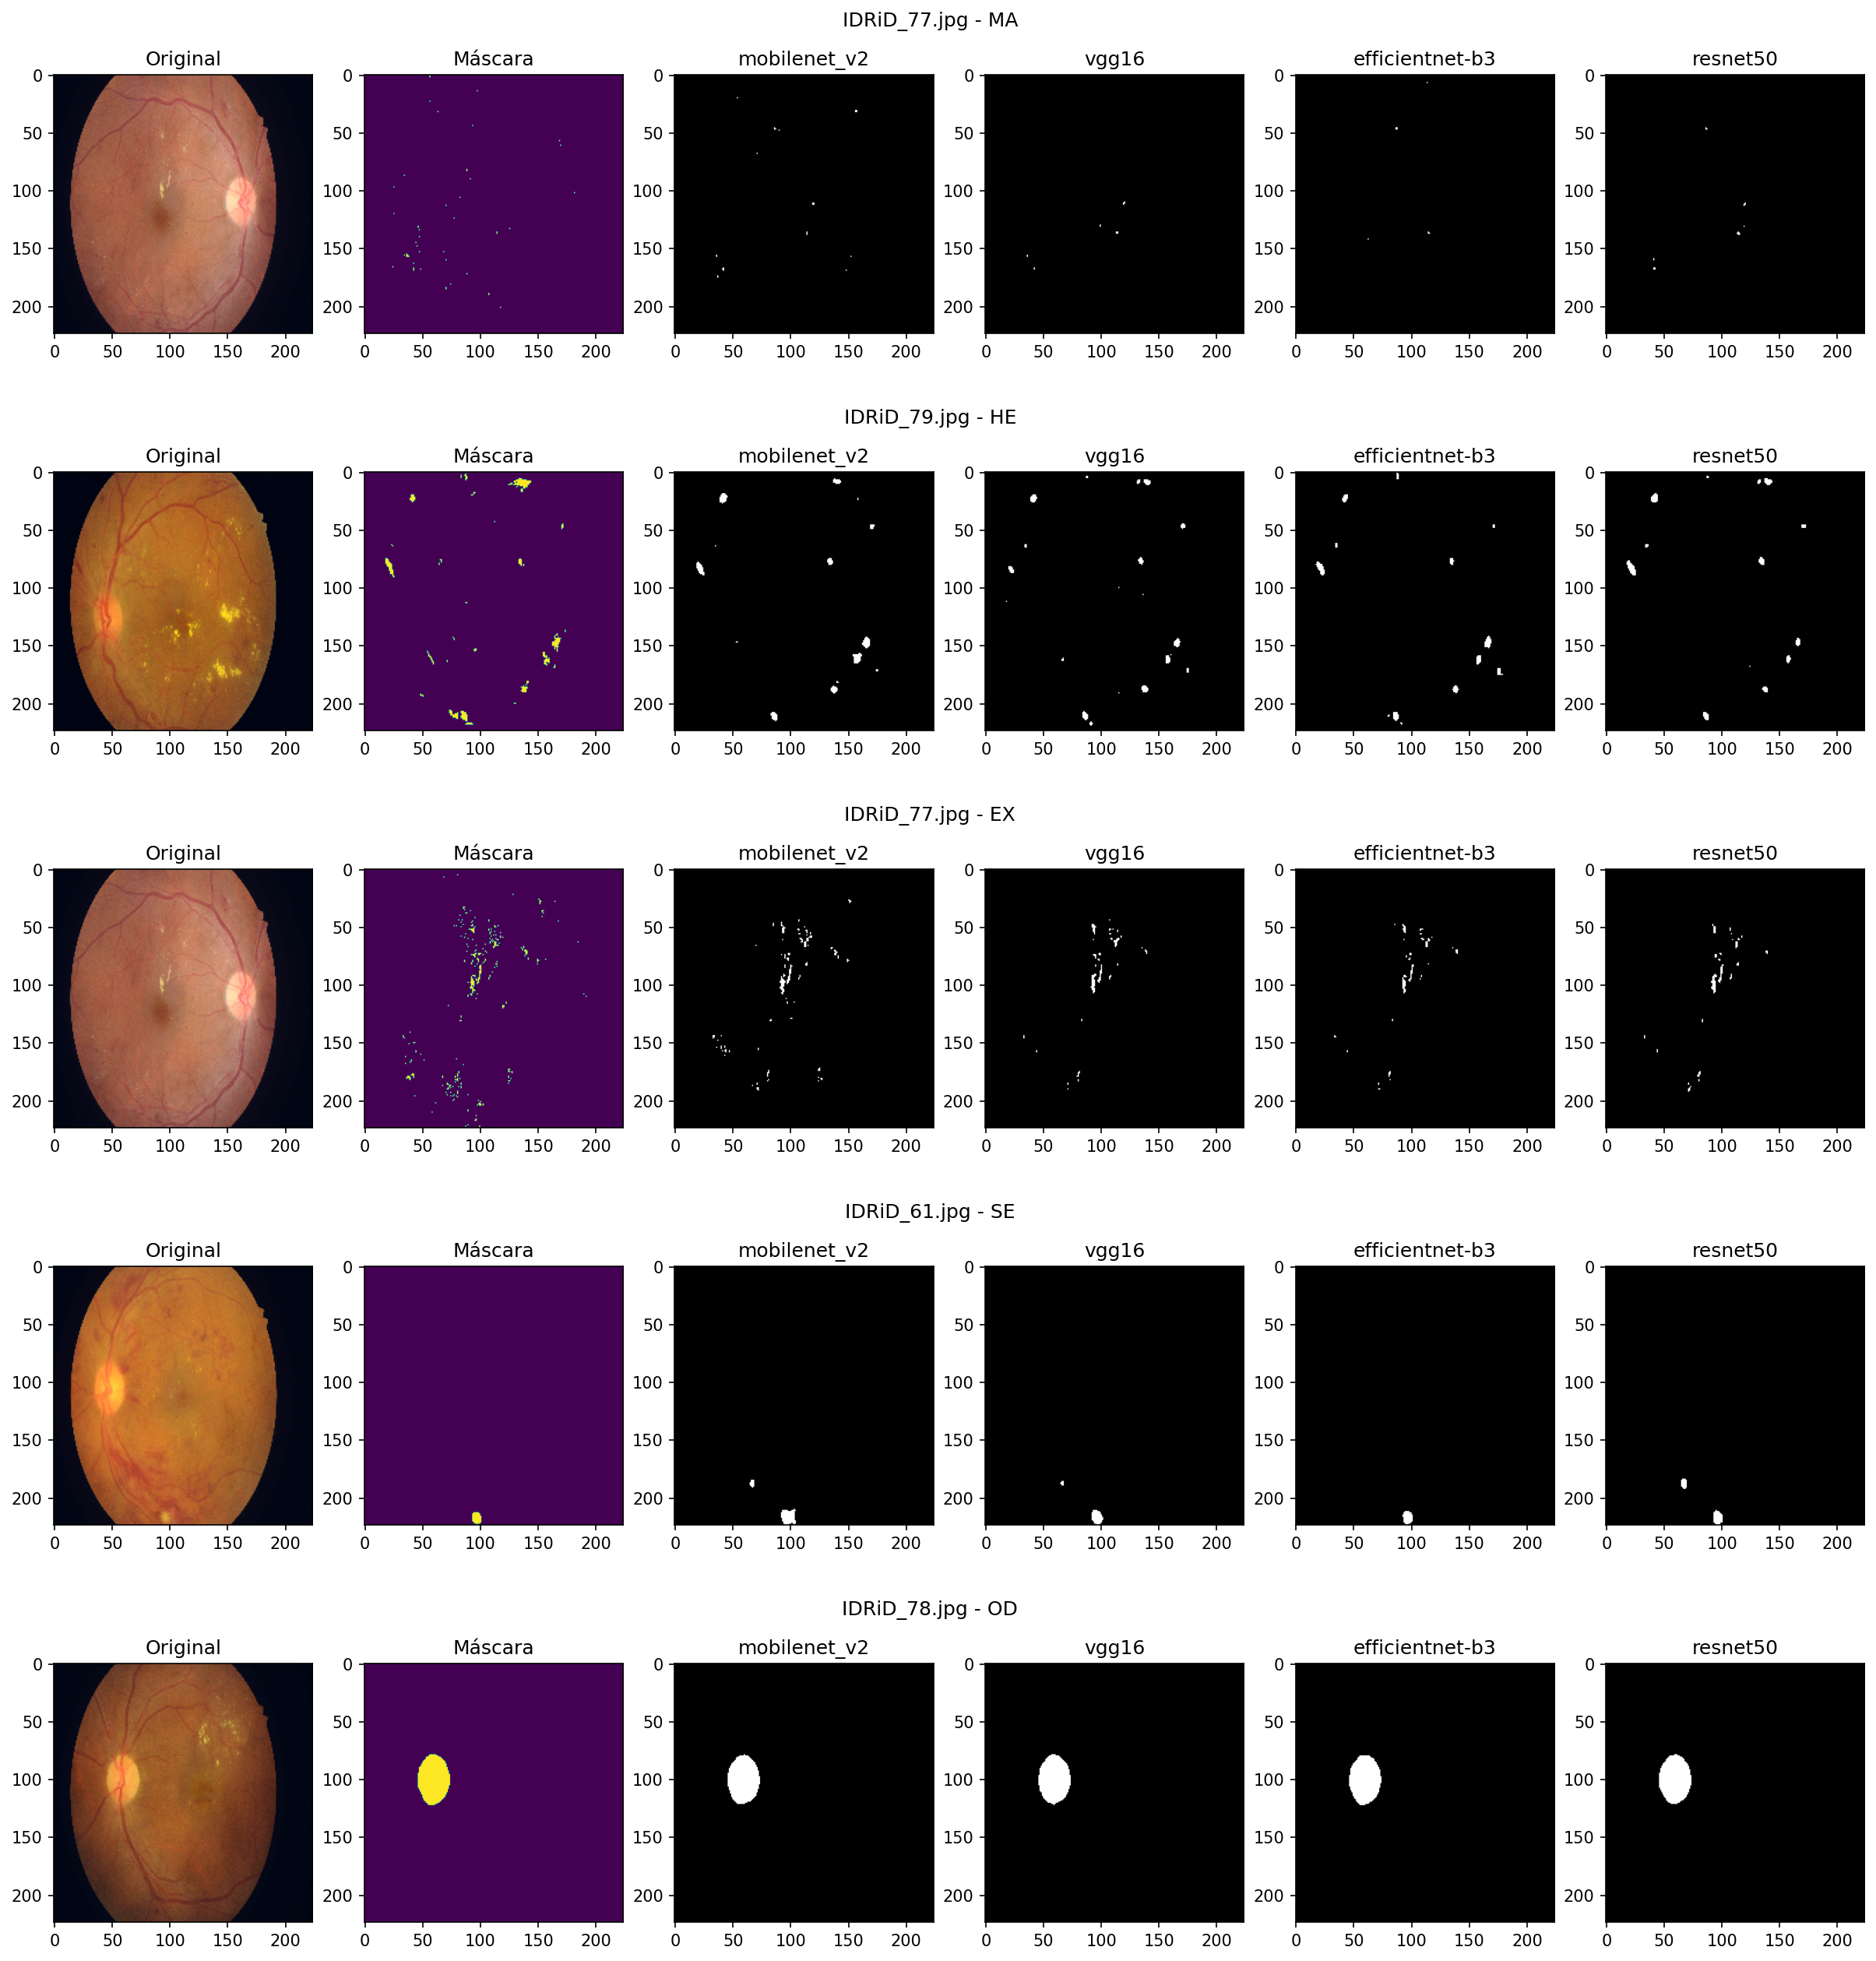

In [ ]:
from functools import total_ordering
# ---------------SUBFIG1-----------------------
#   img      mask     pred     pred   ...

import random
from tqdm.notebook import tqdm


fig = plt.figure(figsize=(20,17), dpi=150)
sfigs = fig.subfigures(5,1) # mudar a quantidade de subfigures conforme a quantidade de lesões


for i, tuple_loader in tqdm(enumerate(dict_dataloader.items()), total=len(dict_dataloader.items())):
  list_batchs = list(iter(tuple_loader[1]))
  jdx = random.randint(0, len(list_batchs) -1)

  images, masks, names = list_batchs[jdx]['image'], list_batchs[jdx]['mask'], list_batchs[jdx]['name_img']

  idx = random.randint(0,images.shape[0]-1)

  normalize = lambda tensor: (tensor - tensor.min()) / (tensor.max() - tensor.min())

  axs = sfigs[i].subplots(1,6)
  axs[0].imshow(normalize(images[idx].permute(1,2,0)))
  axs[0].set_title("Original")
  axs[1].imshow(masks[idx].permute(1,2,0), cmap='viridis')
  axs[1].set_title("Máscara")

  for j, encoder in enumerate(['mobilenet_v2', 'vgg16', 'efficientnet-b3', 'resnet50']):
    model = RetinopatiaModel.load_from_checkpoint(f"./checkpoints/treino-single-class/Unet++_{encoder}_{tuple_loader[0]}.ckpt")
    with torch.no_grad():
        model.eval()
        logits_mask = model(images)
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
    axs[j+2].imshow(pred_mask[idx].permute(1,2,0), cmap='gray')
    axs[j+2].set_title(encoder)

  sfigs[i].suptitle(names[idx]+" - "+tuple_loader[0])

plt.show()
